In [1]:
# pip install pandas numpy scikit-learn matplotlib yfinance


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor

from graphing import graph_normal, show_results
from get_data import get_apple_stock_split

In [3]:
scaler_X = StandardScaler()
scaler_Y = StandardScaler()

X_train, X_test, Y_train, Y_test = get_apple_stock_split(scaler_X, scaler_Y)
print(f"Training samples: {len(X_train)}, Testing samples: {len(X_test)}")

[*********************100%***********************]  1 of 1 completed

Training samples: 1571, Testing samples: 393


<h1> GridSearch setup </h1>

In [5]:
# Define the different hyperparameters
param_grid = {
    'n_estimators': [50, 100, 200],          # Number of trees
    'max_depth': [None, 10, 20, 30],        # Maximum depth of trees
    'min_samples_split': [2, 5, 10],        # Minimum samples to split a node
    'min_samples_leaf': [1, 2, 4],          # Minimum samples per leaf node
}

In [6]:
#training
model = RandomForestRegressor(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=3,                       # cross-validation
    scoring='neg_mean_absolute_error',         # Use mse as scoring
    verbose=1,
    n_jobs=-1                   # Use all available cores
)

# Perform grid search on training data
grid_search.fit(X_train, Y_train)

results_df = pd.DataFrame(grid_search.cv_results_)


Fitting 3 folds for each of 108 candidates, totalling 324 fits


In [7]:
# show_results(grid_search.cv_results_)

Final Model MAE: 0.022129805291699382
Final Model RMSE: 0.03804357936188954


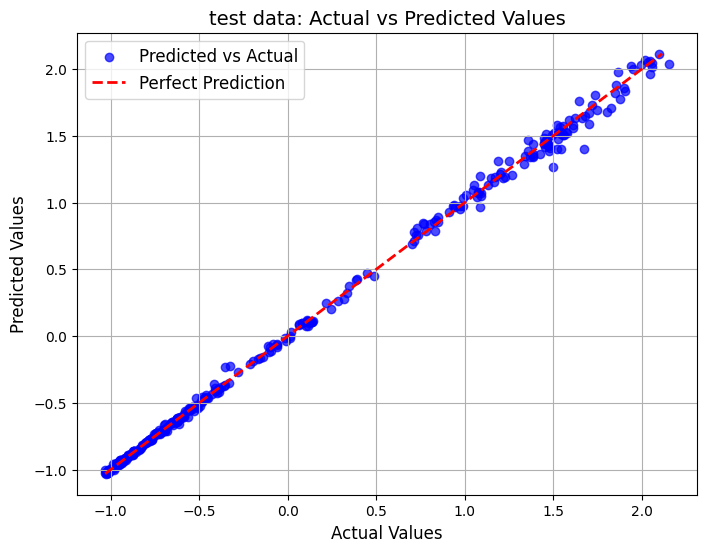

test data  MAE: 0.022129805291699382
test data  RMSE: 0.03804357936188954


In [8]:
# use best model to predict test data
final_model = grid_search.best_estimator_

# Predict on test data
final_predictions = final_model.predict(X_test)

# Evaluate the final model
mae = mean_absolute_error(Y_test, final_predictions)
mse = mean_squared_error(Y_test, final_predictions)
rmse = np.sqrt(mse)

print(f"Final Model MAE: {mae}")
print(f"Final Model RMSE: {rmse}")

graph_normal(final_predictions, Y_test, "test data")

[*********************100%***********************]  1 of 1 completed


Final Model MAE: 0.2844814711931645
Final Model RMSE: 0.34756483223944923


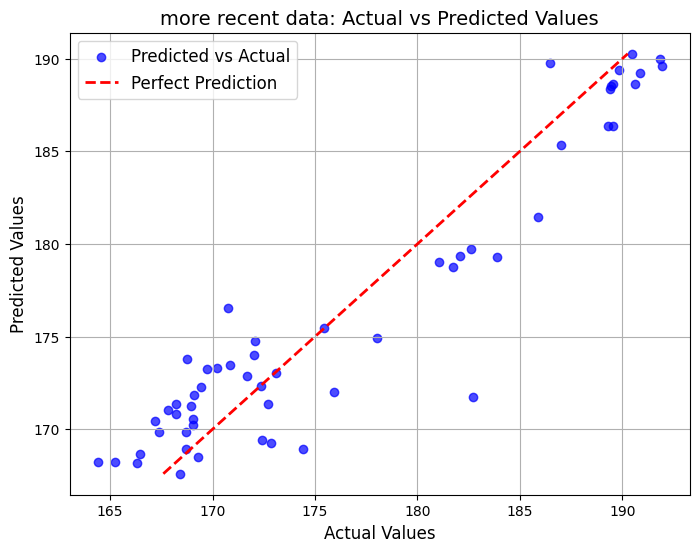

more recent data  MAE: 2.5224481564669285
more recent data  RMSE: 3.0817974424065095


In [9]:
# trying to predict more recent ones
stock = yf.Ticker('AAPL')
data_to_predict = yf.download("AAPL", start="2024-01-01", end="2024-06-01")
data_to_predict['SMA_10'] = data_to_predict['Close'].rolling(window=10).mean()
data_to_predict['SMA_50'] = data_to_predict['Close'].rolling(window=50).mean()
data_to_predict['Price_Change'] = data_to_predict['Close'].pct_change()
data_to_predict['Target'] = data_to_predict['Close'].shift(-1)
data_to_predict.dropna(inplace=True)

X = data_to_predict[['SMA_10', 'SMA_50','Price_Change', 'High', 'Close', 'Open', 'Low']]
Y = data_to_predict['Target']

X_scaled = scaler_X.fit_transform(X)
Y_scaled = scaler_Y.fit_transform(Y.to_frame())

final_predictions = final_model.predict(X_scaled)

inverse_scaled_prediction = scaler_Y.inverse_transform(final_predictions.reshape(-1, 1))

mae = mean_absolute_error(Y_scaled, final_predictions)
mse = mean_squared_error(Y_scaled, final_predictions)
rmse = np.sqrt(mse)

print(f"Final Model MAE: {mae}")
print(f"Final Model RMSE: {rmse}")

graph_normal(inverse_scaled_prediction, Y, "more recent data")

In [10]:
from results import get_num_correct_direction

get_num_correct_direction(inverse_scaled_prediction, Y)

21 correct directions out of a total: 54
